# **Rainfall Prediction Based on Daily and Hourly Weather Data**
Collaborators:
Samatha Marhaendra Putra <br>
Rizky Alif Ramadhan <br>
Daffa Bil Nadzary <br>
<br>

This notebook is created to build a XGBoost model to predict total daily rainfall from a timeseries weather data. The project serves as a workplace for the Arkavidia Data Competition Preliminary Stage hosted in Kaggle: https://www.kaggle.com/competitions/weather-forecasting-datavidia/.

## **1. Preparation**

In this step libraries that has not been installed yet will be installed and loaded

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 'weather-forecasting-datavidia'

 61% 11.0M/17.9M [00:00<00:00, 112MB/s]
100% 17.9M/17.9M [00:00<00:00, 150MB/s]


In [ ]:
!unzip -n /content/weather-forecasting-datavidia.zip

Archive:  /content/weather-forecasting-datavidia.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_hourly.csv         
  inflating: train.csv               
  inflating: train_hourly.csv        


In [ ]:
## Importing all the packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import pprint
from functools import partial
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

In [ ]:
train = pd.read_csv('/content/train.csv')
train_hourly = pd.read_csv('/content/train_hourly.csv')

test = pd.read_csv('/content/test.csv')
test_hourly = pd.read_csv('/content/test_hourly.csv')

submission  = pd.read_csv('/content/sample_submission.csv')

## **2. Data Preprocessing**

### **2.1. Missing Value Handling**

In [ ]:
# Excluding rows that have null value on target feature
del_time = train[train['rain_sum (mm)'].isnull()]['time']
train = train[~train['time'].isin(del_time)]

In [ ]:
# Creating function to inspect total missing values of each column and its percentage
def missing_percentage(df):
    """
    This function takes a DataFrame(df) as input and returns two columns,
    total missing values and total missing values percentage.
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round((df.isnull().sum().sort_values(ascending=False) / len(df) * 100), 2)
    col_miss = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

    return col_miss

In [ ]:
train_miss = missing_percentage(train).reset_index()
train_miss = train_miss[train_miss['Total'] > 0]['index']
missing_percentage(train).reset_index()

,index,Total,Percent
0,winddirection_10m_dominant (°),406,3.08
1,time,0,0.00
2,temperature_2m_max (°C),0,0.00
3,temperature_2m_min (°C),0,0.00
4,apparent_temperature_max (°C),0,0.00
5,apparent_temperature_min (°C),0,0.00
6,sunrise (iso8601),0,0.00
7,sunset (iso8601),0,0.00
8,shortwave_radiation_sum (MJ/m²),0,0.00
9,rain_sum (mm),0,0.00


In [ ]:
train_h_miss = missing_percentage(train_hourly).reset_index()
train_h_miss = train_h_miss[train_h_miss['Total'] > 0]['index']
missing_percentage(train_hourly)

,Total,Percent
winddirection_10m (°),602,0.19
winddirection_100m (°),347,0.11
windspeed_10m (km/h),170,0.05
soil_moisture_100_to_255cm (m³/m³),170,0.05
soil_moisture_7_to_28cm (m³/m³),170,0.05
soil_moisture_0_to_7cm (m³/m³),170,0.05
soil_temperature_100_to_255cm (°C),170,0.05
soil_temperature_28_to_100cm (°C),170,0.05
soil_temperature_7_to_28cm (°C),170,0.05
soil_temperature_0_to_7cm (°C),170,0.05


In [ ]:
test_miss = missing_percentage(test).reset_index()
test_miss = test_miss[test_miss['Total'] > 0]['index']
missing_percentage(test).reset_index()

,index,Total,Percent
0,id,0,0.0
1,time,0,0.0
2,temperature_2m_max (°C),0,0.0
3,temperature_2m_min (°C),0,0.0
4,apparent_temperature_max (°C),0,0.0
5,apparent_temperature_min (°C),0,0.0
6,sunrise (iso8601),0,0.0
7,sunset (iso8601),0,0.0
8,shortwave_radiation_sum (MJ/m²),0,0.0
9,snowfall_sum (cm),0,0.0


In [ ]:
test_h_miss = missing_percentage(test_hourly).reset_index()
test_h_miss = test_h_miss[test_h_miss['Total'] > 0]['index']
missing_percentage(test_hourly).reset_index()

,index,Total,Percent
0,winddirection_100m (°),56,0.05
1,time,0,0.00
2,temperature_2m (°C),0,0.00
3,soil_moisture_100_to_255cm (m³/m³),0,0.00
4,soil_moisture_28_to_100cm (m³/m³),0,0.00
5,soil_moisture_7_to_28cm (m³/m³),0,0.00
6,soil_moisture_0_to_7cm (m³/m³),0,0.00
7,soil_temperature_100_to_255cm (°C),0,0.00
8,soil_temperature_28_to_100cm (°C),0,0.00
9,soil_temperature_7_to_28cm (°C),0,0.00


### **2.2. Changing data type of date-related columns**

In [ ]:
train['time_'] = pd.to_datetime(train['time'])
train['sunrise (iso8601)'] = pd.to_datetime(train['sunrise (iso8601)'])
train['sunset (iso8601)'] = pd.to_datetime(train['sunset (iso8601)'])

test['time_'] = pd.to_datetime(test['time'])
test['sunrise (iso8601)'] = pd.to_datetime(test['sunrise (iso8601)'])
test['sunset (iso8601)'] = pd.to_datetime(test['sunset (iso8601)'])

train_hourly['time_'] = pd.to_datetime(train_hourly['time'])
train_hourly['date'] = pd.to_datetime(train_hourly['time']).dt.date

test_hourly['time_'] = pd.to_datetime(test_hourly['time'])
test_hourly['date'] = pd.to_datetime(test_hourly['time']).dt.date

### **2.3. Imputation**

In [ ]:
# Sorting the data
train = train.sort_values(['city', 'time_'])
train_hourly = train_hourly.sort_values(['city', 'time_'])
test = test.sort_values(['city', 'time_'])
test_hourly = test_hourly.sort_values(['city', 'time_'])

In [ ]:
# Creating new unique id
train['id_'] = train['time'] + train['city']
train_hourly['id_'] = train_hourly['date'].astype(str)+train_hourly['city'].astype(str)
test['id_']= test['time'] + test['city']
test_hourly['id_'] = test_hourly['date'].astype(str)+test_hourly['city'].astype(str)

In [ ]:
# Imputation using `ffill`
for x in train_miss :
    train[x] = train[x].ffill()

for x in train_h_miss :
    train_hourly[x] = train_hourly[x].ffill()

for x in test_miss :
    test[x] = test[x].ffill()

for x in test_h_miss :
    test_hourly[x] = test_hourly[x].ffill()

### **2.4. Creating Aggregated Features**

In [ ]:
# Creating temporary dataframes to store aggregated values of each predictor
min_train = train_hourly.groupby(['id_']).min().reset_index().add_prefix('min_')
q1_train = train_hourly.groupby(['id_']).quantile(0.25).reset_index().add_prefix('q1_')
mean_train = train_hourly.groupby(['id_']).mean().reset_index().add_prefix('mean_')
median_train = train_hourly.groupby(['id_']).median().reset_index().add_prefix('median_')
q3_train = train_hourly.groupby(['id_']).quantile(0.75).reset_index().add_prefix('q3_')
max_train = train_hourly.groupby(['id_']).max().reset_index().add_prefix('max_')
std_train = train_hourly.groupby(['id_']).std().reset_index().add_prefix('std_')

In [ ]:
# Merging temporary dataframes to the daily data
train_ = pd.merge(train, min_train,left_on=['id_'], right_on=['min_id_'], how='inner')
train_ = pd.merge(train_, q1_train,left_on=['id_'], right_on=['q1_id_'], how='inner')
train_ = pd.merge(train_, mean_train,left_on=['id_'], right_on=['mean_id_'], how='inner')
train_ = pd.merge(train_, median_train,left_on=['id_'], right_on=['median_id_'], how='inner')
train_ = pd.merge(train_, q3_train,left_on=['id_'], right_on=['q3_id_'], how='inner')
train_ = pd.merge(train_, max_train,left_on=['id_'], right_on=['max_id_'], how='inner')
train_ = pd.merge(train_, std_train,left_on=['id_'], right_on=['std_id_'], how='inner')

train_ = train_.drop(columns=['min_id_', 'q1_id_', 'mean_id_', 'median_id_', 'q3_id_', 'max_id_', 'std_id_'])

In [ ]:
# Creating temporary dataframes to store aggregated values of each predictor
mean_test = test_hourly.groupby(['id_']).mean().reset_index().add_prefix('mean_')
median_test = test_hourly.groupby(['id_']).median().reset_index().add_prefix('median_')
min_test = test_hourly.groupby(['id_']).min().reset_index().add_prefix('min_')
max_test = test_hourly.groupby(['id_']).max().reset_index().add_prefix('max_')
q1_test = test_hourly.groupby(['id_']).quantile(0.25).reset_index().add_prefix('q1_')
q3_test = test_hourly.groupby(['id_']).quantile(0.75).reset_index().add_prefix('q3_')
std_test = test_hourly.groupby(['id_']).std().reset_index().add_prefix('std_')

In [ ]:
# Merging temporary dataframes to the daily data

test_ = pd.merge(test, min_test,left_on=['id_'], right_on=['min_id_'], how='inner')
test_ = pd.merge(test_, q1_test,left_on=['id_'], right_on=['q1_id_'], how='inner')
test_ = pd.merge(test_, mean_test,left_on=['id_'], right_on=['mean_id_'], how='inner')
test_ = pd.merge(test_, median_test,left_on=['id_'], right_on=['median_id_'], how='inner')
test_ = pd.merge(test_, q3_test,left_on=['id_'], right_on=['q3_id_'], how='inner')
test_ = pd.merge(test_, max_test,left_on=['id_'], right_on=['max_id_'], how='inner')
test_ = pd.merge(test_, std_test,left_on=['id_'], right_on=['std_id_'], how='inner')

test_ = test_.drop(columns=['min_id_', 'q1_id_', 'mean_id_', 'median_id_', 'q3_id_', 'max_id_', 'std_id_'])

### **2.5. Merging Daily Data and Hourly Data**

In [ ]:
# Creating temporary feature called `label` to label each row

train_['label'] = 'train'
test_['label'] = 'test'

In [ ]:
# Set the time column as the index for `df_train_hourly` and `df_test_hourly`
df_train_hourly = train_hourly.set_index('time')
df_test_hourly = test_hourly.set_index('time')

# Convert the index to a datetime index
df_train_hourly.index = pd.to_datetime(df_train_hourly.index)
df_test_hourly.index = pd.to_datetime(df_test_hourly.index)

In [ ]:
df_train_hourly = df_train_hourly.reset_index()
df_test_hourly = df_test_hourly.reset_index()

df_train_hourly['date'] = df_train_hourly.time.dt.date
df_train_hourly['hour'] = df_train_hourly.time.dt.hour
df_test_hourly['date'] = df_test_hourly.time.dt.date
df_test_hourly['hour'] = df_test_hourly.time.dt.hour

In [ ]:
df_train_hourly.drop(['time'], axis=1, inplace=True)
df_test_hourly.drop(['time'], axis=1, inplace=True)

In [ ]:
df_train_hourly = pd.pivot_table(df_train_hourly, index=['date', 'city'], columns='hour')
df_test_hourly = pd.pivot_table(df_test_hourly, index=['date', 'city'], columns='hour')

In [ ]:
df_train_hourly.columns = [col[0] + "_" + str(col[1]) for col in df_train_hourly.columns]
df_test_hourly.columns = [col[0] + "_" + str(col[1]) for col in df_test_hourly.columns]

In [ ]:
df_train_hourly = df_train_hourly.reset_index()
df_test_hourly = df_test_hourly.reset_index()

In [ ]:
# Set the time column as the index for `df_train`
df_train = train_.set_index('time')

# Convert the index to a datetime index
df_train.index = pd.to_datetime(df_train.index)

df_train = df_train.reset_index()

df_train['date'] = df_train.time.dt.date

df_train.drop(['time'], axis=1, inplace=True)

In [ ]:
df_train_merged = pd.merge(df_train, df_train_hourly, left_on=['date', 'city'], right_on=['date', 'city'])

In [ ]:
# Set the time column as the index for `df_test`
df_test = test_.set_index('time')

# Convert the index to a datetime index
df_test.index = pd.to_datetime(df_test.index)

df_test = df_test.reset_index()

df_test['date'] = df_test.time.dt.date

df_test.drop(['time'], axis=1, inplace=True)

In [ ]:
df_test_merged = pd.merge(df_test, df_test_hourly, left_on=['date', 'city'], right_on=['date', 'city'])

In [ ]:
train = df_train_merged
test = df_test_merged

In [ ]:
train.shape, test.shape

((13198, 959), (4972, 959))

## **3. Feature Engineering**

### **3.1. Extracting Date Properties**

In [ ]:
# Concatenating the train and test data
df = pd.concat([train,test]).sort_values(by=['time_','city']).reset_index(drop=True)

# Extracting various date properties, then assign its value to new columns
df['dayofweek'] = df['time_'].dt.dayofweek.astype(int)
df['is_weekend'] = ((df['time_'].dt.dayofweek.astype(int)) > 5).map({True:1,False:0})
df['dayofyear'] = df['time_'].dt.dayofyear.astype(int)
df['weakofyear'] = df['time_'].dt.weekofyear.astype(int)
df['week'] = df['time_'].dt.week.astype(int)
df['day'] = df['time_'].dt.day.astype(int)
df['month'] = df['time_'].dt.month.astype(int)
df['year'] = df['time_'].dt.year.astype(int)
df['quarter'] = df['time_'].dt.quarter.astype(int)
df['is_month_start'] = df['time_'].dt.is_month_start.astype(int)
df['is_month_end'] = df['time_'].dt.is_month_end.astype(int)
df['is_quarter_end'] = df['time_'].dt.is_quarter_end.astype(int)
df['is_quarter_start'] = df['time_'].dt.is_quarter_start.astype(int)
df['is_year_end'] = df['time_'].dt.is_year_end.astype(int)
df['is_year_start'] = df['time_'].dt.is_year_start.astype(int)
df['is_leap_year'] = df['time_'].dt.is_leap_year.astype(int)

In [ ]:
# Creating `day_length` and `night_length` features in minutes
df['day_length'] = (df['sunset (iso8601)'] - df['sunrise (iso8601)']).dt.seconds.astype(int) / 60

q_day = df[(df['day_length'] != 0) & (df['city'] == 'q')][['time_', 'day_length']].sort_values(by='time_')
q_day['time'] = q_day['time_']
q_day = q_day.set_index('time_')

q_day['quarter'] = q_day['time'].dt.quarter.astype(int)
mean_day_length = q_day.groupby('quarter')['day_length'].mean().reset_index()

index_0 = df[df['day_length'] == 0].index

for i in np.array(index_0):
    if df.loc[i, 'quarter'] == 1:
      df.loc[i, 'day_length'] = 561.147368
    elif df.loc[i, 'quarter'] == 2:
      df.loc[i, 'day_length'] = 1108.078947
    elif df.loc[i, 'quarter'] == 3:
      df.loc[i, 'day_length'] = 946.060870
    elif df.loc[i, 'quarter'] == 4:
      df.loc[i, 'day_length'] = 415.848837

df['night_length'] = 1440-df['day_length']

In [ ]:
# Checking for correlations between each predictor and target feature
df.corr()['rain_sum (mm)'].reset_index().sort_values(by='rain_sum (mm)', ascending=False)

,index,rain_sum (mm)
5,rain_sum (mm),1.000000
219,std_soil_moisture_7_to_28cm (m³/m³),0.675172
220,std_soil_moisture_28_to_100cm (m³/m³),0.627361
218,std_soil_moisture_0_to_7cm (m³/m³),0.585394
499,relativehumidity_2m (%)_13,0.565076
...,...,...
766,surface_pressure (hPa)_16,-0.486928
763,surface_pressure (hPa)_13,-0.487056
764,surface_pressure (hPa)_14,-0.487280
765,surface_pressure (hPa)_15,-0.487439


In [ ]:
train_ = df[df['label'] == 'train']
test_ = df[df['label'] == 'test']

In [ ]:
train = train_.sample(train_.shape[0])
test = test_.sample(test_.shape[0])

### **3.2. Encoding Categorical Feature**

In [ ]:
# One hot encoding on `city` feature
cat_features = ['city']

for feature in cat_features:
    a = pd.get_dummies(train[feature], prefix=feature)
    frames = [train, a]
    train = pd.concat(frames, axis=1)

    b = pd.get_dummies(test[feature], prefix=feature)
    frames = [test, b]
    test = pd.concat(frames, axis=1)

In [ ]:
# Saving preprocessed train and test data as csv files
train.to_csv('train_clean.csv', index=False)
test.to_csv('test_clean.csv', index=False)

In [ ]:
X = train.select_dtypes(include=['float', 'int'])
X = X.drop(columns=['rain_sum (mm)', 'id'])

X_test = test.select_dtypes(include=['float', 'int'])
X_test = X_test.drop(columns=['id'])

y = train[['rain_sum (mm)']]

X_test = X_test[X.columns]

### **3.3. Normalization**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scale = MinMaxScaler()

X = pd.DataFrame(scale.fit_transform(X.values), columns=X.columns, index=X.index)
X_test = pd.DataFrame(scale.transform(X_test.values), columns=X_test.columns, index=X_test.index)

In [ ]:
X_test_ = X_test

### **3.4. Feature Selection**

In [ ]:
# ANOVA test
from sklearn.feature_selection import f_regression

f_score, p_value = f_regression(X, y)
f_test = pd.DataFrame()
f_test['Variabel'] = X.columns
f_test['f_score'] = f_score
f_test['p_value'] = p_value
f_test = f_test.sort_values(by=['f_score'], ascending=False)
f_test.head(20)

,Variabel,f_score,p_value
218,std_soil_moisture_7_to_28cm (m³/m³),11054.981011,0.0
219,std_soil_moisture_28_to_100cm (m³/m³),8564.577258,0.0
217,std_soil_moisture_0_to_7cm (m³/m³),6879.652060,0.0
498,relativehumidity_2m (%)_13,6190.249811,0.0
497,relativehumidity_2m (%)_12,6133.490480,0.0
499,relativehumidity_2m (%)_14,6034.605556,0.0
42,q1_relativehumidity_2m (%),5935.415809,0.0
496,relativehumidity_2m (%)_11,5892.484537,0.0
500,relativehumidity_2m (%)_15,5838.139024,0.0
495,relativehumidity_2m (%)_10,5635.151845,0.0


In [ ]:
# Selecting features that have p-value below .05
sel = np.array(f_test[(f_test['p_value'] < 0.05) & (~f_test['p_value'].isnull())]['Variabel'])

X = X[sel]
X_test = X_test[sel]

In [ ]:
X.shape, X_test.shape

((13198, 938), (4972, 938))

## **4. Modelling**

### **4.1. Preparation**

In [ ]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-w7n5n560
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-w7n5n560
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=4173dbc5334bc0f190693c09cce7ee965ce6e0a289c87c4820d9a4988674f1d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-60ddpce_/wheels/40/48/e7/8f8bf2b4c2c847051cfaac9d3603002e5109468805dcc72b3a
Successfully built scikit-optimize


In [ ]:
# Skopt functions
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import DeltaYStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

In [ ]:
"""
A wrapper for measuring time and performances of different optmizers

optimizer = a sklearn or a skopt optimizer
X = the training set
y = our target
title = a string label for the experiment
"""

def report_perf(optimizer, X, y, title, callbacks=None):
    start = time()
    if callbacks:
      optimizer.fit(X, y, callback=callbacks)
    else:
      optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start,
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))
    print('Best parameters:')
    pprint.pprint(best_params)
    print()

    return best_params

In [ ]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=True),
                      greater_is_better=False)

In [ ]:
# 5-fold StratifiedCV
kf = KFold(n_splits=5, shuffle=True, random_state=8)

In [ ]:
def cv_mse(model, X, y):
  mse = (-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
  return (mse)

### **4.2. XGBRegressor**

In [ ]:
# Setting the basic regressor
reg = XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist')

In [ ]:
# Setting the search space
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'uniform'),
    'max_depth': Integer(2, 12),
    'subsample': Real(0.1, 1.0, 'uniform'),
    'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
    'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
    'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
    'n_estimators': Integer(50, 5000)
    }

In [ ]:
opt = BayesSearchCV(estimator=reg,
                    search_spaces=search_spaces,
                    scoring=scoring,
                    cv=kf,
                    n_jobs=1,
                    n_iter=20,
                    return_train_score=False,
                    refit=True,
                    iid=False,                                        # if not iid it optimizes on the cv score
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0,
                    verbose=100)

In [ ]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)  # We stop if the gain of the optimization becomes too small

best_params_xgb = report_perf(opt, X, y, 'XGBRegressor',
                              callbacks=[overdone_control])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 1/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=-40.724 total time=  47.7s
[CV 2/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 2/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=-48.399 total time=  46.6s
[CV 3/5; 1/1] START colsamp

In [ ]:
# Setting up the best params
best_params_xgb = {
    'learning_rate': 0.07767866742287785,
    'max_depth': 5,
    'subsample':  0.6807161976101201,
    'colsample_bytree': 0.5737547253606028,
    'reg_lambda': 35.87270784309438,
    'reg_alpha': 23.459722486222752,
    'n_estimators': 1085}

In [ ]:
# Transferring the best parameters to our basic regressor
xgb_tuned = XGBRegressor(**best_params_xgb, tree_method='gpu_hist')

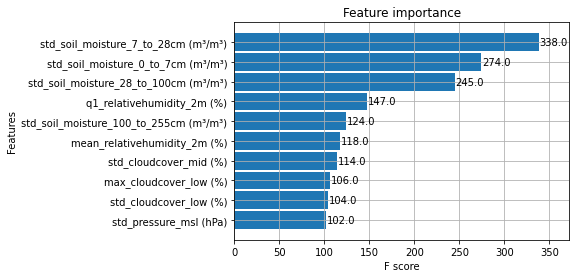

In [ ]:
from xgboost import plot_importance, plot_tree

xgb_tuned.fit(X, y)
_ = plot_importance(xgb_tuned, height=0.9, max_num_features=10)

In [ ]:
score = cv_mse(xgb_tuned, X, y)
print('XGB Tuned: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

XGB Tuned: 15.0076 (2.2177)



### **4.3. LGBMRegressor**

In [ ]:
# Setting the basic regressor
reg2 = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         metric='rmse',
                         device='gpu',
                         n_jobs=1,
                         verbose=-1,
                         random_state=0)

In [ ]:
# Setting the search space
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(1, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

In [ ]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,
                    search_spaces=search_spaces,
                    scoring=scoring,
                    cv=kf,
                    n_iter=20,                                        # max number of trials
                    n_jobs=1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,
                    refit=False,
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0,
                    verbose=100)                                   # random state for replicability

In [ ]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)           # We stop if the gain of the optimization becomes too small

best_params_lgbm = report_perf(opt, X , y, 'LGBMRegressor',
                               callbacks=[overdone_control])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START colsample_bytree=0.5356545233026259, learning_rate=0.22498782522548938, max_depth=159, n_estimators=3244, num_leaves=440, reg_alpha=61.11092950683307, reg_lambda=2.563039028690693e-08, subsample=0.01162059109844919, subsample_freq=6
[CV 1/5; 1/1] END colsample_bytree=0.5356545233026259, learning_rate=0.22498782522548938, max_depth=159, n_estimators=3244, num_leaves=440, reg_alpha=61.11092950683307, reg_lambda=2.563039028690693e-08, subsample=0.01162059109844919, subsample_freq=6;, score=-23938.779 total time=  17.5s
[CV 2/5; 1/1] START colsample_bytree=0.5356545233026259, learning_rate=0.22498782522548938, max_depth=159, n_estimators=3244, num_leaves=440, reg_alpha=61.11092950683307, reg_lambda=2.563039028690693e-08, subsample=0.01162059109844919, subsample_freq=6
[CV 2/5; 1/1] END colsample_bytree=0.5356545233026259, learning_rate=0.22498782522548938, max_depth=159, n_estimators=3244, num_leaves=440, reg_al

In [ ]:
# Setting up the best params
best_params_lgbm = {
    'colsample_bytree': 0.5334048246546964,
    'learning_rate': 0.013055565482435798,
    'max_depth':  87,
    'n_estimators': 982,
    'num_leaves': 125,
    'reg_alpha': 5.799589814357769e-06,
    'reg_lambda': 0.011556350804882232,
    'subsample': 0.4144872817307234,
    'subsample_freq': 8}

In [ ]:
# Transferring the best parameters to our basic regressor
lgbm_tuned = lgb.LGBMRegressor(boosting_type='gbdt',
                               objective='regression',
                               metric='mse',
                               device='gpu',
                               n_jobs=1,
                               verbose=-1,
                               random_state=0,
                               **best_params_lgbm)

In [ ]:
score = cv_mse(lgbm_tuned, X, y)
print("LGBM Tuned: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

### **4.4. Creating Submission File**

#### **4.4.1 XGBRegressor**

In [ ]:
y_pred = xgb_tuned.predict(X_test)

In [ ]:
test['rain_sum (mm)'] = y_pred

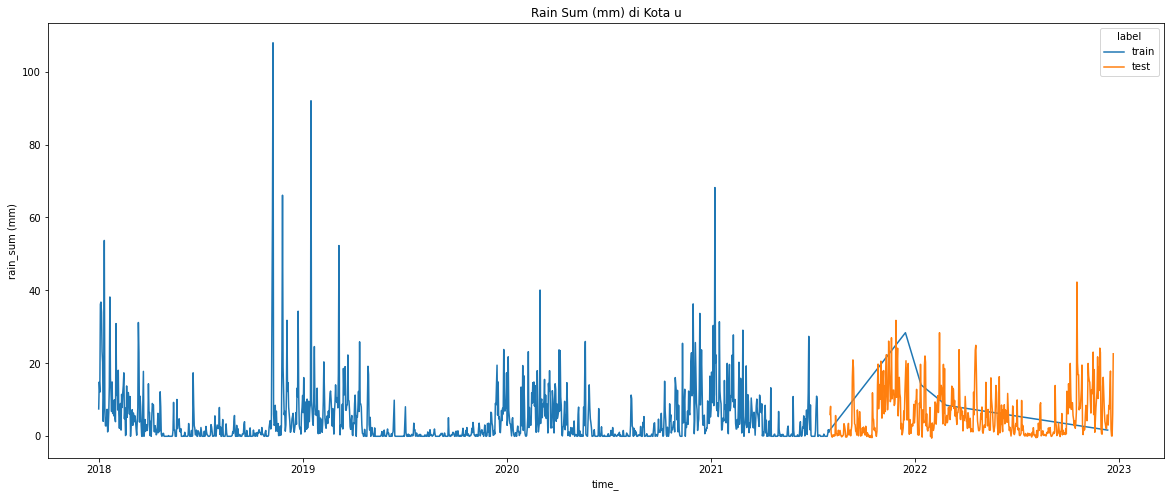

<Figure size 432x288 with 0 Axes>

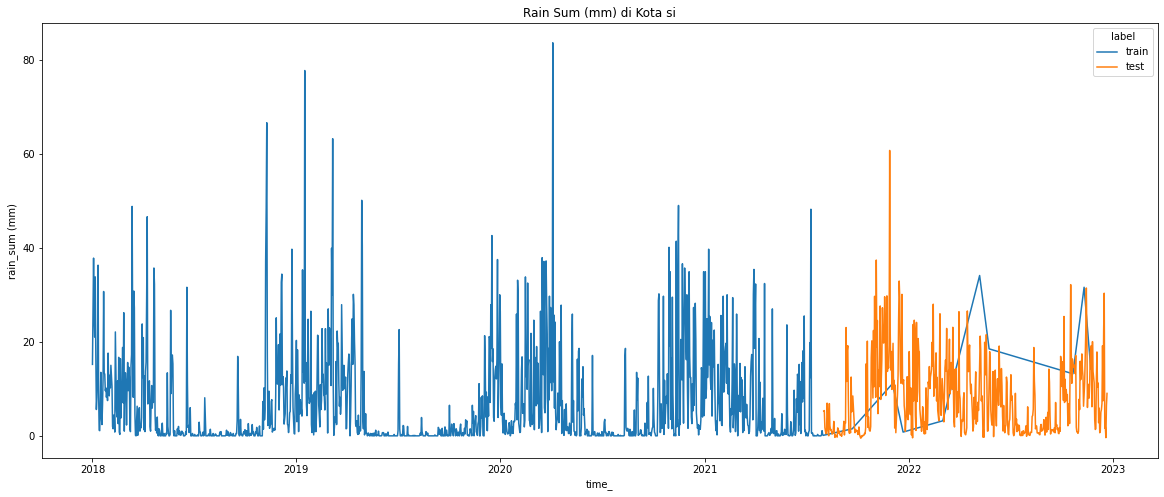

<Figure size 432x288 with 0 Axes>

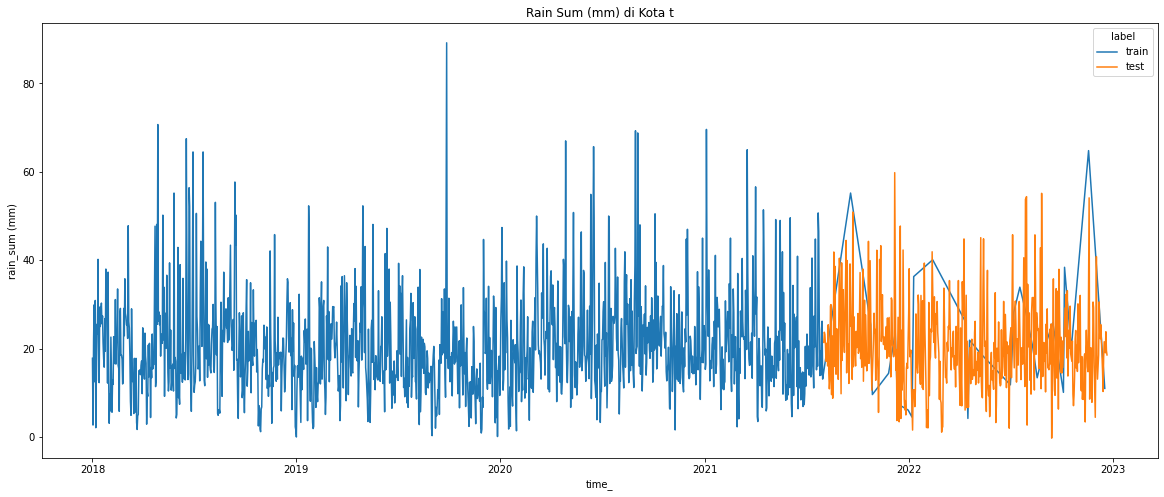

<Figure size 432x288 with 0 Axes>

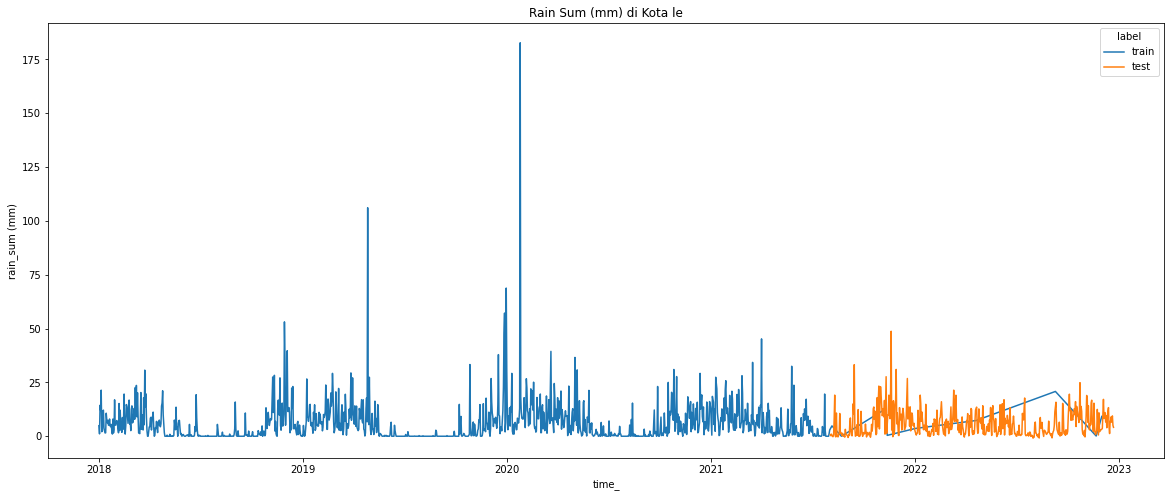

<Figure size 432x288 with 0 Axes>

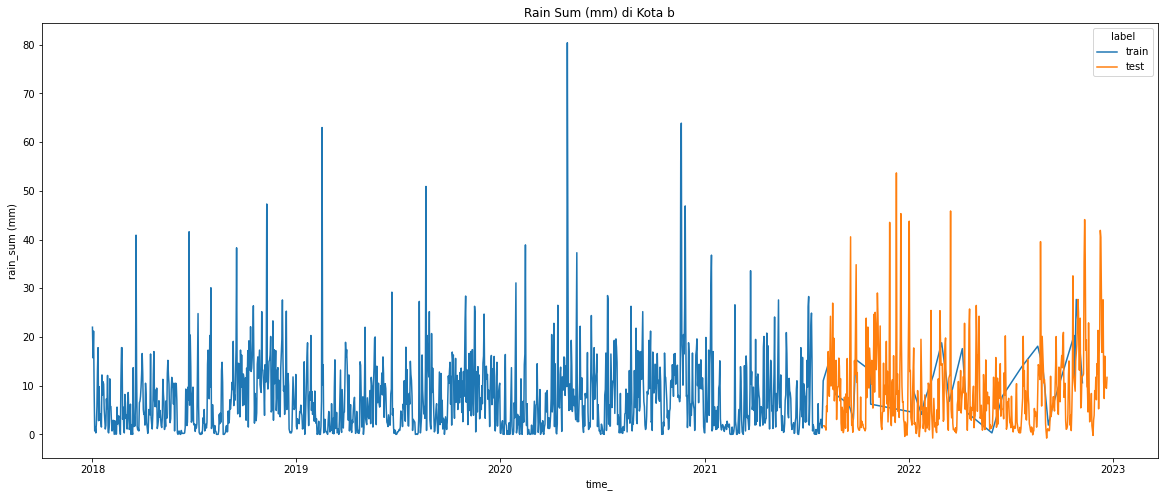

<Figure size 432x288 with 0 Axes>

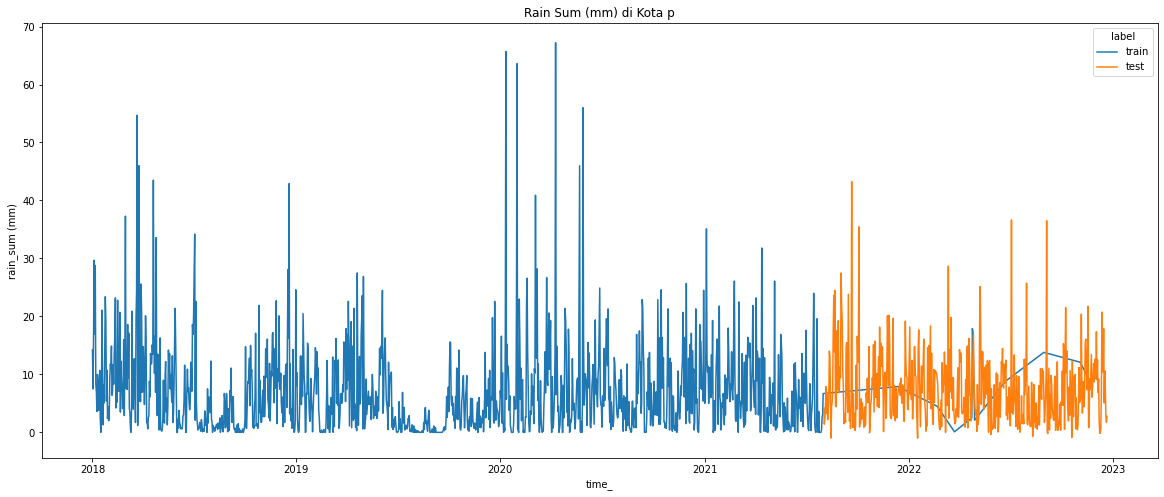

<Figure size 432x288 with 0 Axes>

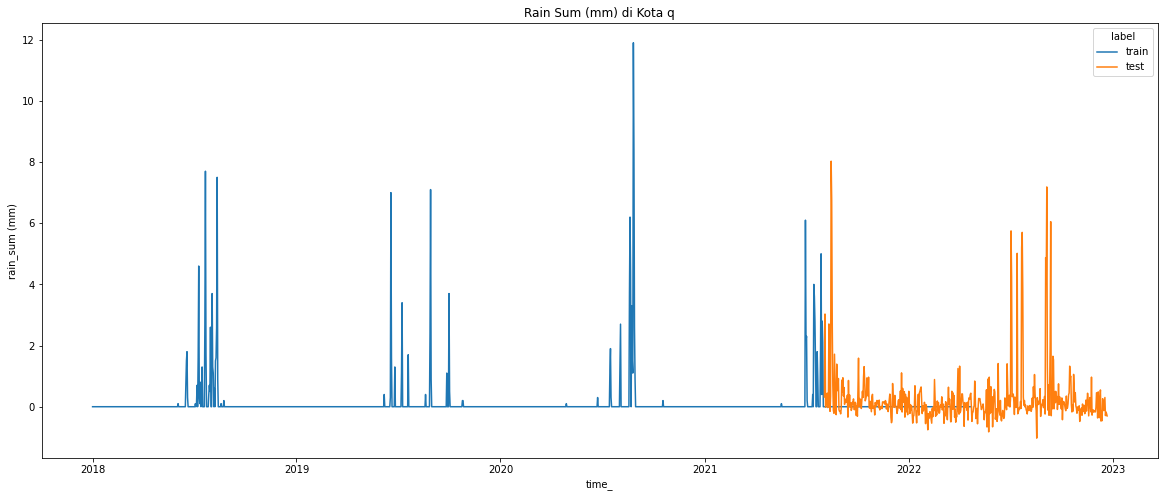

<Figure size 432x288 with 0 Axes>

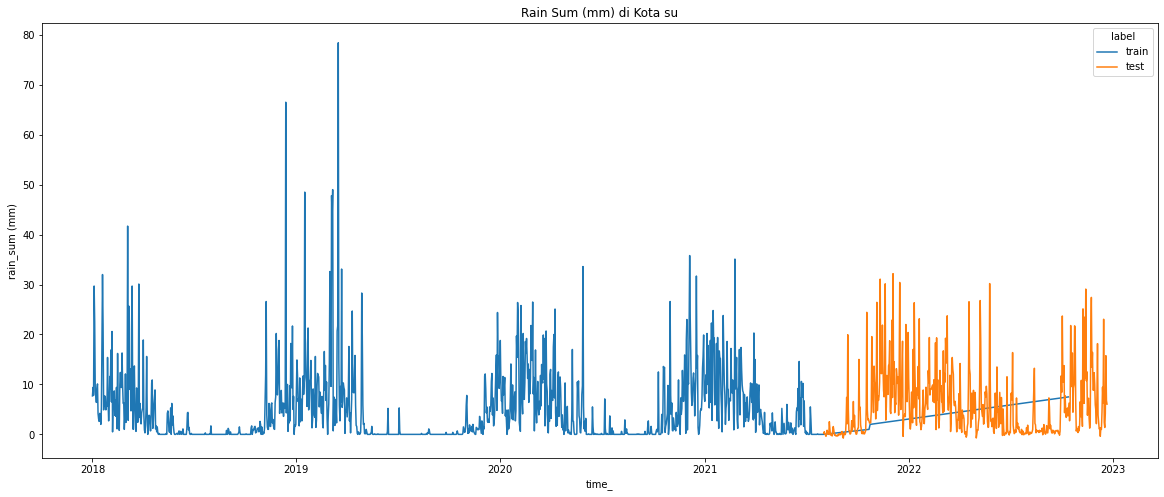

<Figure size 432x288 with 0 Axes>

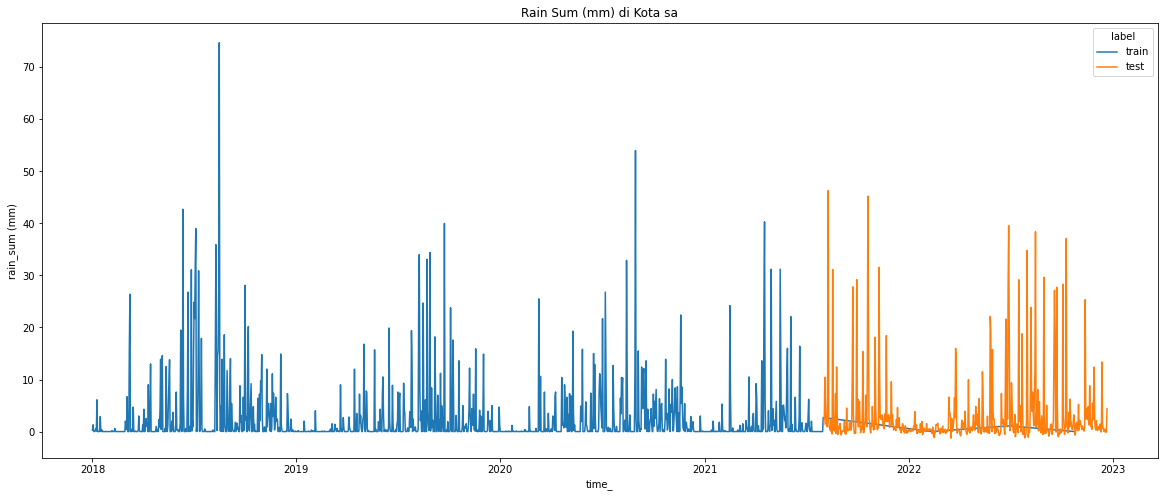

<Figure size 432x288 with 0 Axes>

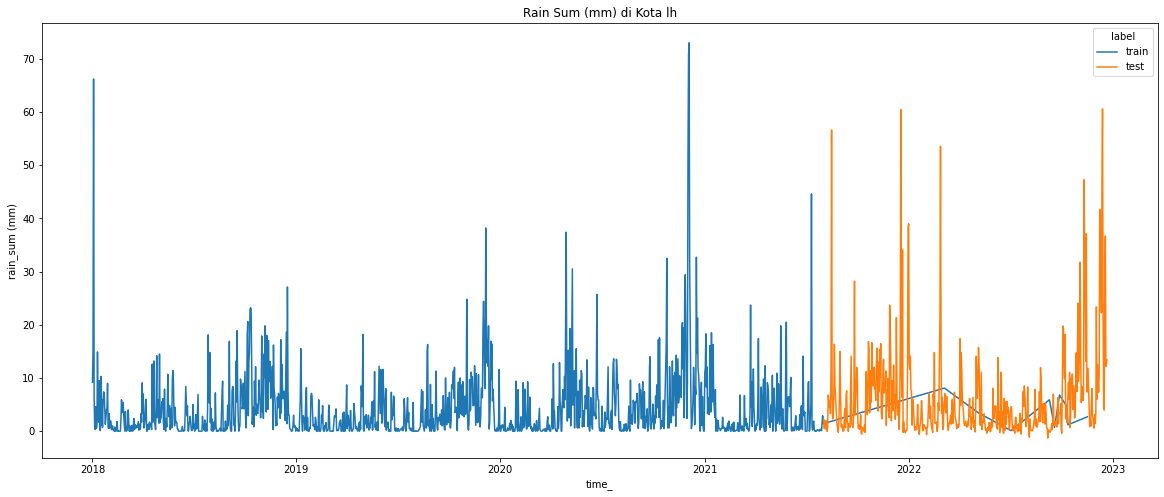

<Figure size 432x288 with 0 Axes>

In [ ]:
df_ = pd.concat([train, test]).sort_values(by='time_')

for x in df_['city'].unique() :
  df_city = df_[df_['city'] == x]
  fig, ax = plt.subplots(figsize=(20, 8))
  sns.lineplot(x='time_', y='rain_sum (mm)', data=df_city, hue='label')
  plt.title('Rain Sum (mm) at Kota '+str(x))
  plt.show()
  plt.savefig('Rain Sum (mm) at Kota '+str(x)+'.png')

In [ ]:
submission_ = test[['id', 'rain_sum (mm)']]
submission_ = submission_[~submission_['id'].isnull()].reset_index(drop=False).sort_values(by='id')

In [ ]:
submission = submission_.reset_index(drop=True)
submission['id'] = submission['id'].astype(int)
submission = submission.drop(columns='index')

In [ ]:
submission

,id,rain_sum (mm)
0,0,0.223396
1,1,0.535051
2,2,0.037786
3,3,-0.111958
4,4,-0.386251
...,...,...
4967,4967,0.301898
4968,4968,-0.289670
4969,4969,-0.172741
4970,4970,-0.228900


In [ ]:
submission.to_csv('submission_xgbr.csv', index=False)

#### **4.4.2 LGBMRegressor**

In [ ]:
y_pred = lgbm_tuned.predict(X_test)

In [ ]:
test['rain_sum (mm)'] = y_pred

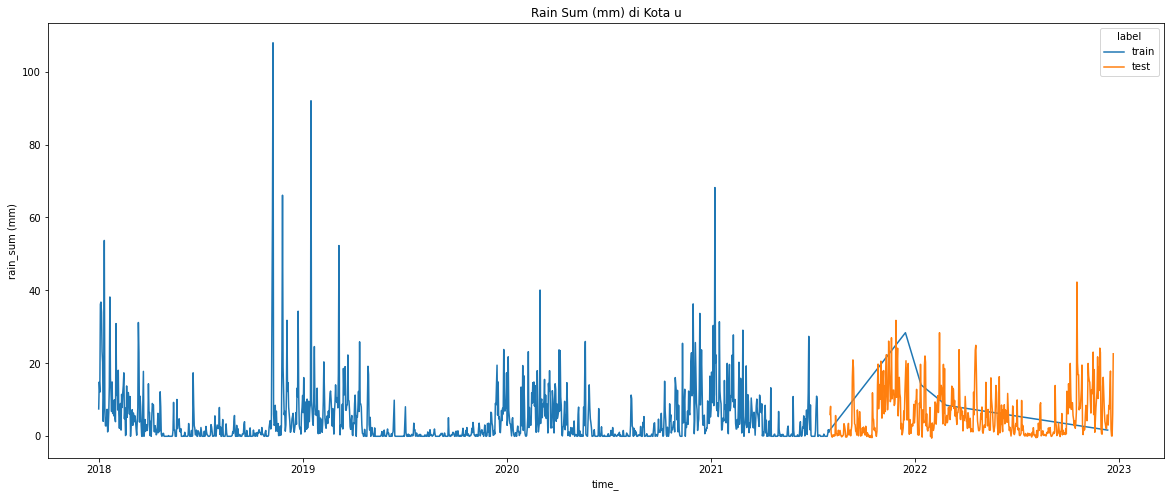

<Figure size 432x288 with 0 Axes>

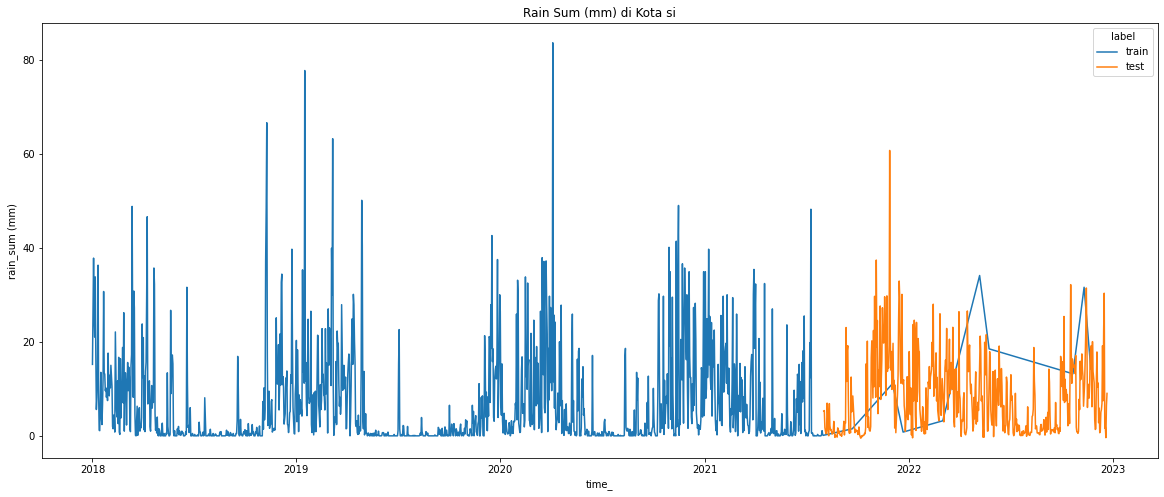

<Figure size 432x288 with 0 Axes>

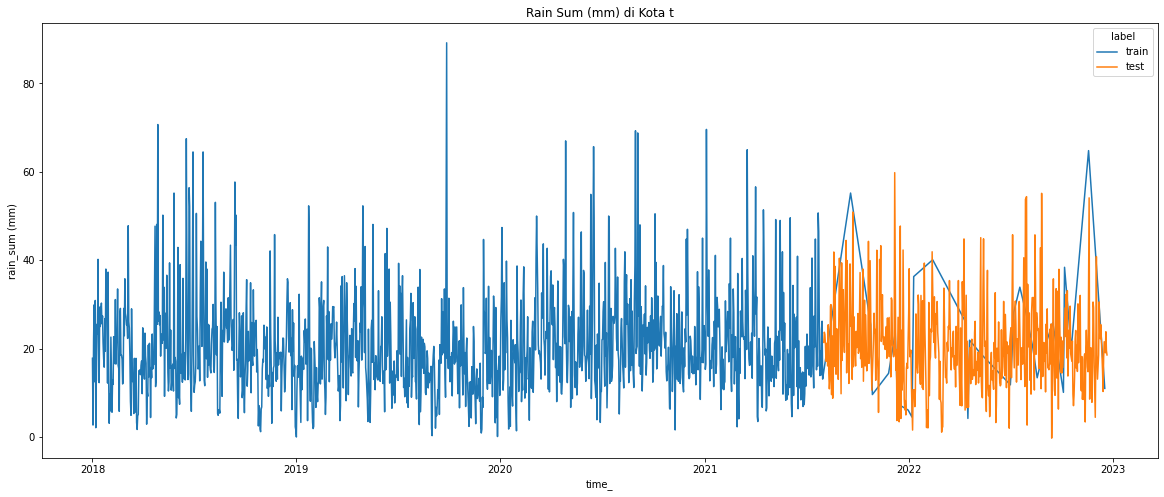

<Figure size 432x288 with 0 Axes>

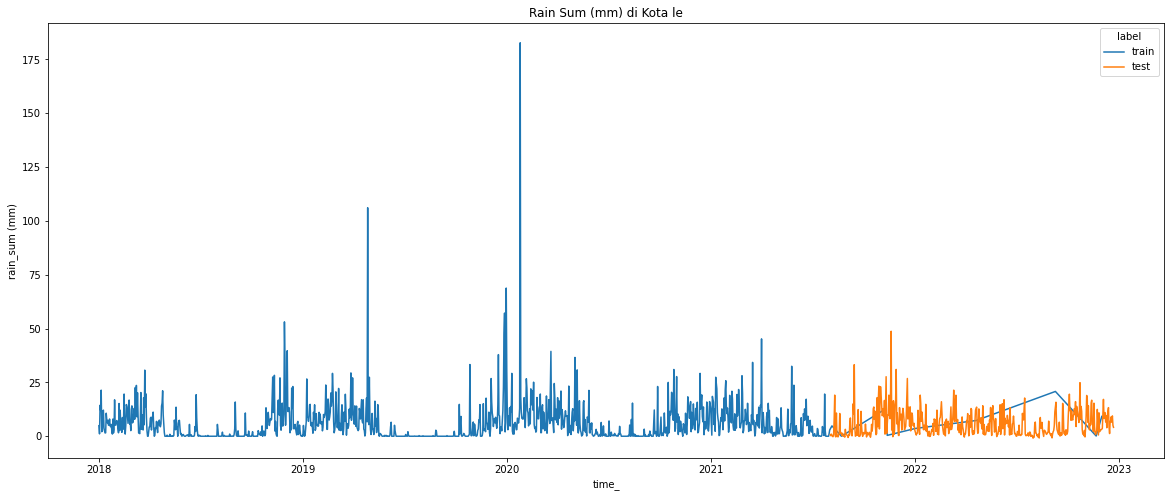

<Figure size 432x288 with 0 Axes>

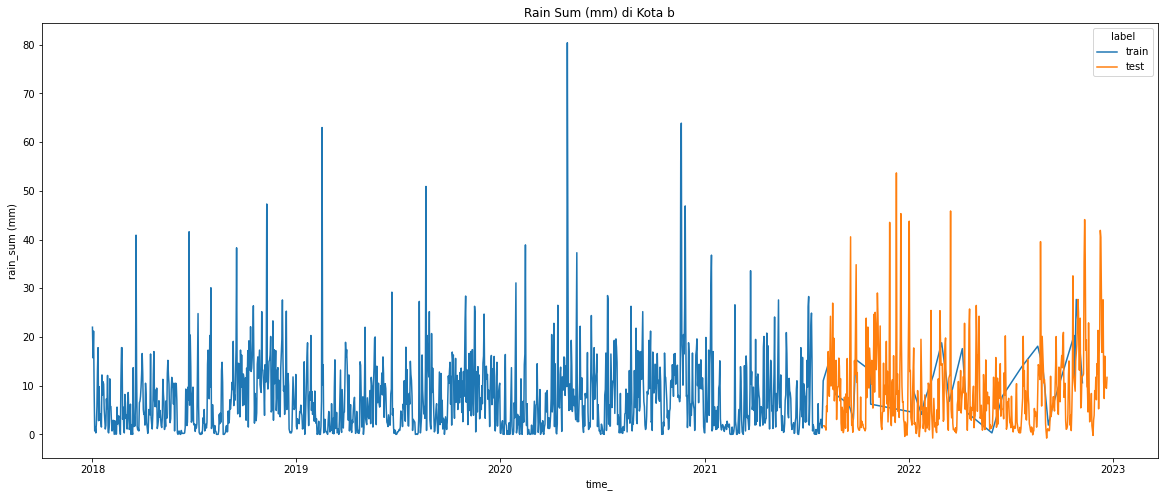

<Figure size 432x288 with 0 Axes>

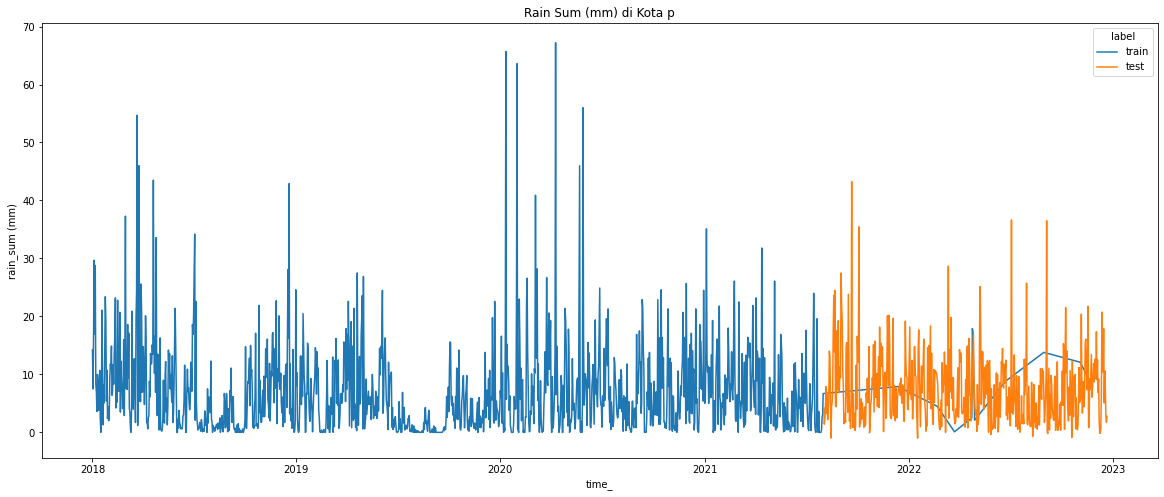

<Figure size 432x288 with 0 Axes>

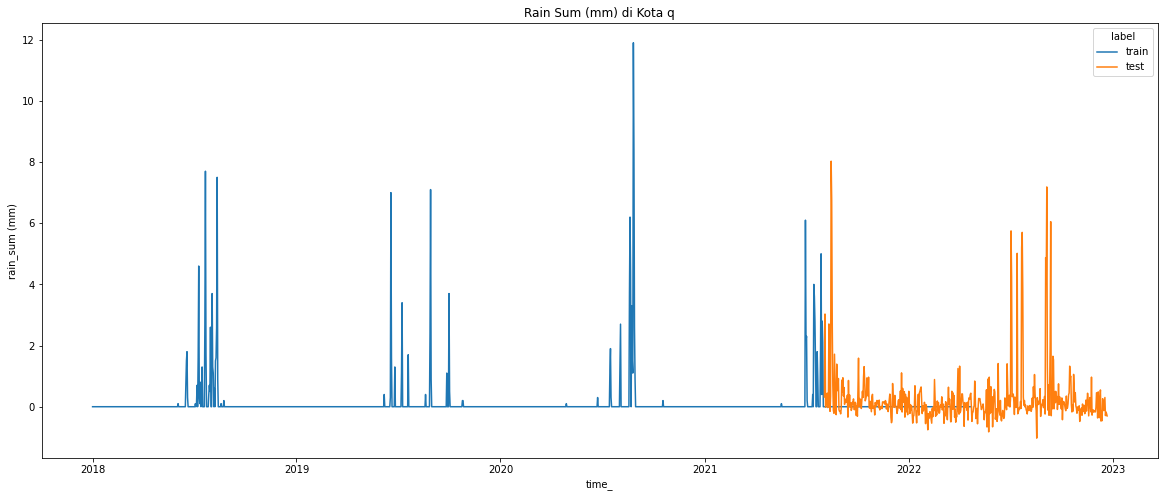

<Figure size 432x288 with 0 Axes>

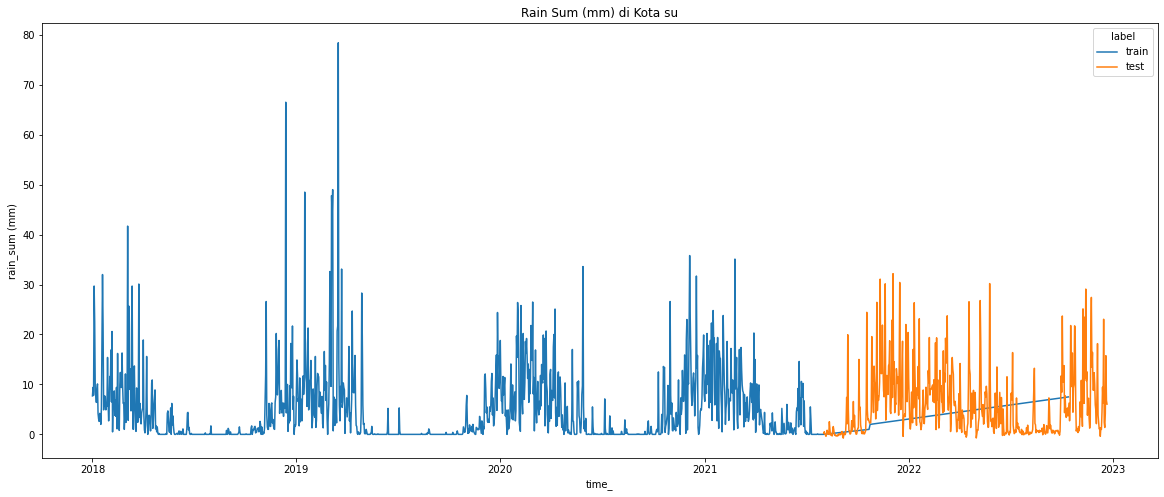

<Figure size 432x288 with 0 Axes>

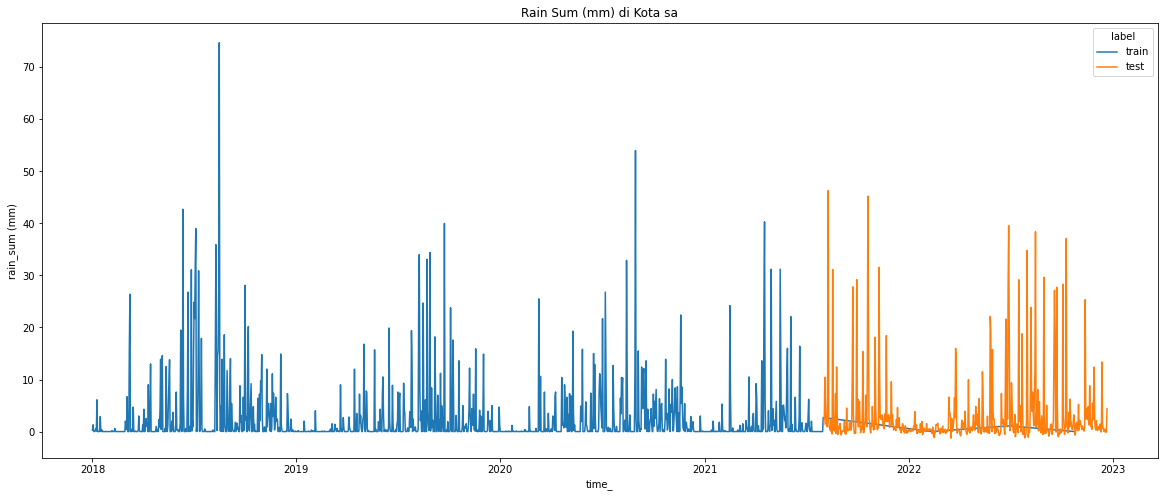

<Figure size 432x288 with 0 Axes>

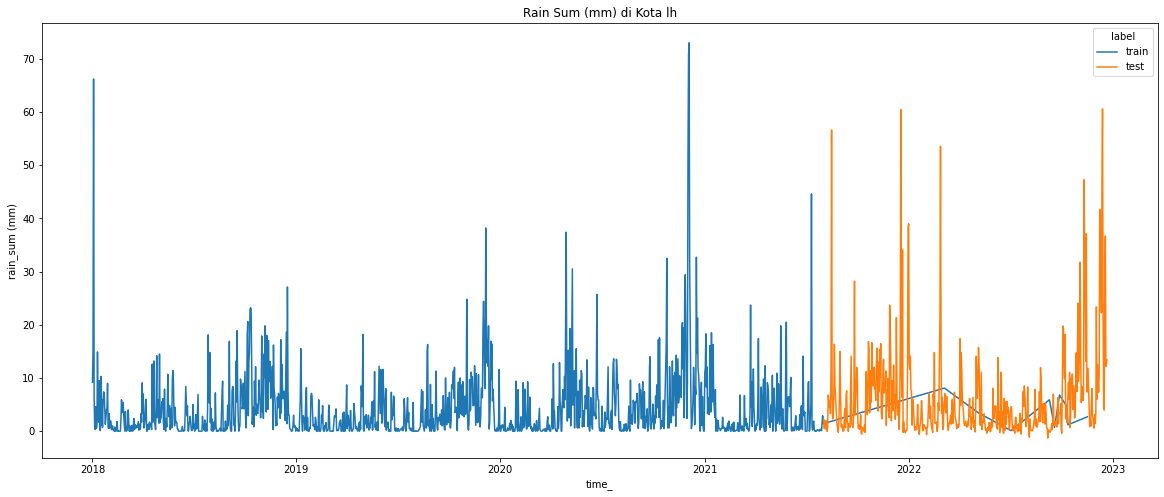

<Figure size 432x288 with 0 Axes>

In [ ]:
df_ = pd.concat([train, test]).sort_values(by='time_')

for x in df_['city'].unique() :
  df_city = df_[df_['city'] == x]
  fig, ax = plt.subplots(figsize=(20, 8))
  sns.lineplot(x='time_', y='rain_sum (mm)', data=df_city, hue='label')
  plt.title('Rain Sum (mm) at Kota '+str(x))
  plt.show()
  plt.savefig('Rain Sum (mm) at Kota '+str(x)+'.png')

In [ ]:
submission_ = test[['id', 'rain_sum (mm)']]
submission_ = submission_[~submission_['id'].isnull()].reset_index(drop=False).sort_values(by='id')

In [ ]:
submission = submission_.reset_index(drop=True)
submission['id'] = submission['id'].astype(int)
submission = submission.drop(columns='index')

In [ ]:
submission

,id,rain_sum (mm)
0,0,0.223396
1,1,0.535051
2,2,0.037786
3,3,-0.111958
4,4,-0.386251
...,...,...
4967,4967,0.301898
4968,4968,-0.289670
4969,4969,-0.172741
4970,4970,-0.228900


In [ ]:
submission.to_csv('submission_lgbm.csv', index=False)